In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

In [2]:
syscoord = 'examples/phenanthrene_rot.xyz'

In [3]:
# Read the geometry (only Cs)
f = open(syscoord)
for l in f:
    row = l.split()
    nV = int(row[0])
    f.next()
    break
V = np.empty(shape=[0,3])
for l in f:
    row = l.split()
    if row[0] == 'C':
        V = np.append(V, [[row[1], row[2], row[3]]], axis=0)
f.close()
V = V.astype(np.float64)
nV = len(V)
print(V)

[[ 17.16445485  17.58356989   5.55602069]
 [ 18.42306402  18.0069131    5.99951082]
 [ 20.75399114  12.44073318   6.90748645]
 [ 22.01260031  12.86407639   7.35097658]
 [ 17.55612379  13.90518737   5.74601397]
 [ 18.52575288  12.96128867   6.10500514]
 [ 19.78436205  13.38463188   6.54849527]
 [ 20.07334213  14.75187379   6.63299422]
 [ 21.33195129  15.175217     7.07648435]
 [ 22.30158038  14.23131829   7.43547553]
 [ 16.87547478  16.21632799   5.47152174]
 [ 17.84510387  15.27242928   5.83051292]
 [ 19.10371304  15.69577249   6.27400305]
 [ 19.39269311  17.0630144    6.358502  ]]


In [4]:
# rotate to the xy plane if needed
def aunit(array):
    """ Returns the unit array """
    return array / np.linalg.norm(array)

def aangle(a1, a2):
    """ Returns the angle in radians between arrays 'a1' and 'a2' """
    a1_u = aunit(a1)
    a2_u = aunit(a2)
    return np.arccos(np.clip(np.dot(a1_u, a2_u), -1.0, 1.0))

def axyproj(array):
    """ Returns the an equiarrayalent 2D structure rotated to the xy plane """
    u1 = aunit(array[1]-array[0])
    u2 = array[2]-array[0]
    u3 = aunit(np.cross(u1, u2))
    u2 = aunit(np.cross(u3, u1))
    proj = np.linalg.inv([u1, u2, u3])
    array = np.matmul(array, proj)
    if np.max(array[:,2])-np.min(array[:,2]) > 0.01:
        raise ValueError('Structure is not planar!')
    return np.delete(array, 2, axis=1)

V = axyproj(V)
print(V)

[[ 22.50804674 -11.31196143]
 [ 23.90804674 -11.31196143]
 [ 24.60804675  -5.24978362]
 [ 26.00804675  -5.24978362]
 [ 21.80804674  -7.67465474]
 [ 22.50804674  -6.46221918]
 [ 23.90804674  -6.46221918]
 [ 24.60804675  -7.67465474]
 [ 26.00804674  -7.67465475]
 [ 26.70804674  -6.46221917]
 [ 21.80804675 -10.09952588]
 [ 22.50804675  -8.8870903 ]
 [ 23.90804675  -8.8870903 ]
 [ 24.60804675 -10.09952587]]


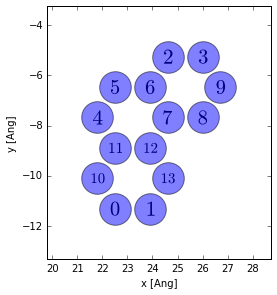

In [5]:
# visualize the structure
f, axs = plt.subplots(1, 1, figsize=(4, 10))
lb_x = V[:,0]
for j in range(nV):
    axs.scatter(V[j,0], V[j,1], s=200, c='black',
                marker=r"$ {} $".format(str(j)), edgecolors='none')
    axs.scatter(V[j,0], V[j,1], s=1000, c='b', alpha=.5)
axs.set_xlim(min(V[:,0])-2., max(V[:,0])+2.);
axs.set_ylim(min(V[:,1])-2., max(V[:,1])+2.);
axs.set_xlabel('x [Ang]'); axs.set_ylabel('y [Ang]'); axs.set_aspect('equal');

In [6]:
# build the first-neighbours Hamiltonian
def close(iv, V, rad):
    """ Returns an array off 1st neighbours indexes """
    idx = np.empty(shape=[0], dtype=np.int32)
    for i in range(iv):
        if np.linalg.norm(V[i]-V[iv]) < rad:
            idx = np.append(idx, [[i]])
    for i in range(iv+1,len(V)):
        if np.linalg.norm(V[i]-V[iv]) < rad:
            idx = np.append(idx, [[i]])
    return idx

H = np.zeros(shape=[nV, nV], dtype=np.uint8)
for i in range(nV):
    # list nearest neighbours
    idx = close(i, V, 1.43)
    # nearest neighbours hopping
    H[i, idx] = 1
    # put 1 in the diagonal when necessary
    H[i, i] = 3-len(idx)

print(' ', end='')
for i in range(nV):
    print('%2d'%i, end='')
print('')
print(H)

  0 1 2 3 4 5 6 7 8 910111213
[[1 1 0 0 0 0 0 0 0 0 1 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 1 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 1 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 1 0 0 0 1 0 1]
 [0 1 0 0 0 0 0 0 0 0 0 0 1 1]]
